In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
from evaluation_functions import ensemble_evaluation_functions as eef

import matplotlib as mpl
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin

import scipy.interpolate
from scipy import integrate
from scipy.optimize import curve_fit

from sunpy.coordinates.sun import carrington_rotation_time
import astropy.units as u

from sklearn.calibration import calibration_curve
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

### Functions

In [2]:
def read_deterministic_forecast_cdf(cr):
    ### Reads in deterministic forecast runs
    input_file = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\deterministic_forecasts\\deterministic_CR{cr}.nc'

    # Read the NetCDF file into an xarray Dataset
    loaded_ds = xr.open_dataset(input_file)

    df = loaded_ds.sel().to_dataframe()

    return df

def compute_roc_score(roc_curve):
    """
    Computes integrates area under ROC curve using scipy quad returning integrated area as the ROC score

    Parameters:
    - roc_curve (list): list of tuples which each contain the hit rate and false alarm rate calculated at different thresholds

    Returns:
    - result (float): ROC Score calculated as the integrated area under ROC curve
    """

    # Unpack and prepare roc curve data
    y,x = zip(*roc_curve)

    x = np.array([xx for xx in x])
    y = np.array([yy for yy in y])

    nan_mask_x = ~np.isnan(x)
    nan_mask_y = ~np.isnan(y)

    nan_mask = np.logical_and(nan_mask_x, nan_mask_y)

    x = x[nan_mask]
    y = y[nan_mask]

    # Interpolate the curve
    interp_function = scipy.interpolate.interp1d(x, y, kind='linear')

    # Define the integration limits
    a = min(x)
    b = max(x)

    # Perform the integration
    result, error = integrate.quad(interp_function, a, b)

    return result


def interpolate_and_resample(observed_data_index, forecast_index, forecast):
    
    # This function runs an interpolation algorithm on forecast output and outputs a resamples forecast series on the omni data timestep
    Int = scipy.interpolate.CubicSpline(forecast_index, forecast)

    interpolated_forecast_output = Int(observed_data_index)

    return interpolated_forecast_output


def perturb_longitude(long_pert_dt, ensemble_member):
    
    # Ensure that the DataFrame has a datetime index
    if not isinstance(ensemble_member.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a datetime index")
    
    shift_amount = int(long_pert_dt.to(u.second).value) # Convert shift amount into seconds

    # Convert datetime index into integers
    numeric_index = ensemble_member.index.astype(int) // 10**9 # Floor division to convert into seconds (UNIX int datetime is in nanoseconds)
    numeric_index = numeric_index.to_numpy()

    # Calculate the new index by shifting with wrapping
    shifted_index = numeric_index + shift_amount

    # Generate boolean array which captures elements above and below max/min indices
    wrap_mask = (shifted_index < numeric_index.min()) | (shifted_index > numeric_index.max())
  
    if shift_amount < 0:
        # If negative shift amount (i.e. elements will be below min index)
        shifted_index[wrap_mask] = shifted_index[wrap_mask] + (shifted_index.max() - shifted_index.min())

    elif shift_amount > 0:
        # If positive shift amount (i.e. elements will be above max index)  
        shifted_index[wrap_mask] = shifted_index[wrap_mask] - (shifted_index.max() - shifted_index.min())

    else:
        # No change -- preserve original index
        shifted_index = numeric_index

    # Convert back to datetime index
    new_converted_index = pd.to_datetime(shifted_index, unit='s')

    # Sort the DataFrame based on the new index
    df_shifted = ensemble_member.copy()
    df_shifted = (df_shifted.sort_index().set_index(new_converted_index)).sort_index()
    df_shifted = df_shifted[~(df_shifted.index).duplicated()].copy()

    # Interpolate shifted dataframe back onto orignal datetime axis (for more ease in later analysis)
    Int = scipy.interpolate.CubicSpline(df_shifted.index, df_shifted['vsw'])
    data_time_axis = ensemble_member.index
    interpolated_forecast_output = Int(data_time_axis)
    
    return pd.DataFrame({'vsw':interpolated_forecast_output}, index = data_time_axis)


def gen_ranked_ensemble(ensemble_members, omni_data): 

    vsw_list = [] # Initialise list for forecast output

    # Prepare data for rank comparison
    omni_chunk = omni_data.loc[pd.to_datetime(ensemble_members[0].index[0]):pd.to_datetime(ensemble_members[0].index[-1])]
 
    omni_chunk = omni_chunk.dropna(subset = ['V']) # Remove rows with NaN values

    # Interpolate and resample forecast output onto OMNI data time step
    for vsw in ensemble_members:
        vsw_int = interpolate_and_resample(observed_data_index = omni_chunk.index, forecast_index=vsw.index, forecast=vsw['vsw'])
        vsw_list.append(vsw_int)

    # Compare ensemble member output arrays to omni data 
    vsw_arr = np.array(vsw_list)
    ranked_forecast_boolean = np.array([vsw < omni_chunk['V'] for vsw in vsw_arr])
    summed_ranks = np.sum(ranked_forecast_boolean, axis = 0)
    
    return summed_ranks

def calculate_rank_chi_square(ensemble_size, ranked_forecasts):
        
    ensemble_hist = np.histogram(ranked_forecasts, bins = ensemble_size)[0]

    chi_sq_alt = 0 
    
    for i in range(ensemble_size):
        
        chi_sq_alt += (ensemble_hist[i]/np.sum(ensemble_hist) - 1/(ensemble_size+1))**2

    chi_sq_alt = chi_sq_alt*np.sum(ensemble_hist)*(ensemble_size+1)

    return chi_sq_alt




### Read in and prepare OMNI data

In [3]:
# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\OMNI\\Processed_omni\\'

# load the data into dataframe and index by datetime
omni_data = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_data = omni_data.set_index('datetime')
omni_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

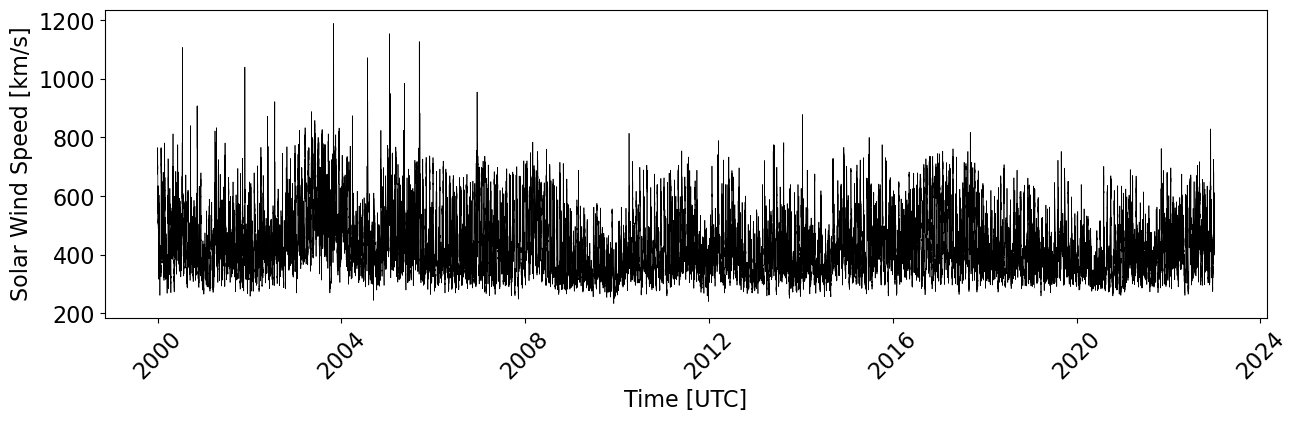

In [4]:
plt.figure(figsize = (15,4))

plt.plot(omni_data['V'], lw = 0.5, color = 'black')

plt.xlabel('Time [UTC]')
plt.ylabel('Solar Wind Speed [km/s]')
plt.xticks(rotation = 45)
#plt.legend(frameon = False, fontsize = 'small')
plt.show()

### Define ensemble parameters

In [5]:
# Range of carrington rotations
cr_min = 2078
cr_max = 2120
cr_list = np.arange(cr_min,cr_max)
carrington_rotation = 27.2753*u.day

ensemble_size = 100

# Perturbation parameters
lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))



### Define time frames to evaluate over

In [6]:
CR_year_dict = {2009:np.arange(2079,2092),
                2010:np.arange(2092,2106),
                2011:np.arange(2106,2119),
                2012:np.arange(2119,2133),
                2013:np.arange(2133,2146),
                2014:np.arange(2146,2159),
                2015:np.arange(2159,2173),
                2016:np.arange(2173,2186),
                2017:np.arange(2186,2200),
                2018:np.arange(2200,2213),
                2019:np.arange(2213,2226)}

### Read in ensemble sets over desired time frame (for a specific $\sigma_{latitude}$)

In [7]:
CR_chunk = CR_year_dict[2018] # one year of carrington rotations

lat_dev = lat_dev_list[3] # pick a latitudinal perturbation

ensemble_sets = [] # List to store each CR ensemble set 

# Read in ensemble members per CR
for CR in CR_chunk:
    ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
    ensemble_members = [df.set_index('datetime') for df in ensemble_members]
    ensemble_sets.append(ensemble_members)

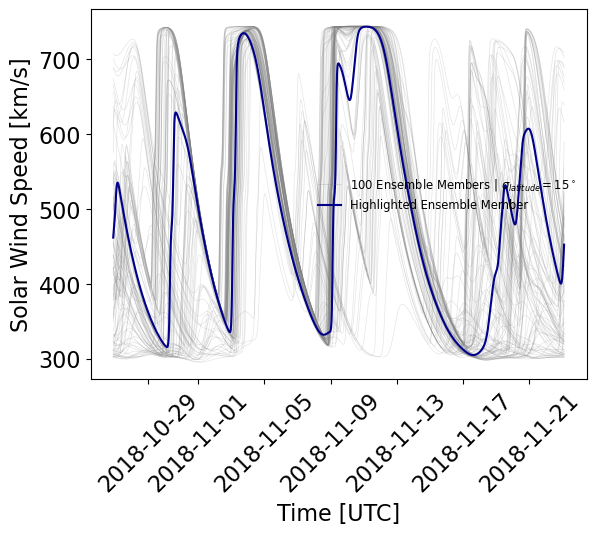

In [21]:
idx_set = 10 # ensemble set index (i.e. single carrington rotation)
idx = 1 # ensemble member index

for df in ensemble_sets[idx_set]:
    plt.plot(df['vsw'], color = 'grey', alpha = 0.2, lw = 0.5)

plt.plot(df['vsw'], color = 'grey', alpha = 0.3, lw = 0.5, label = f'{ensemble_size} Ensemble Members | $\sigma_{{latitude}}={lat_dev}^\circ$')
plt.plot(ensemble_sets[idx_set][idx]['vsw'], color = 'darkblue', label = 'Highlighted Ensemble Member')

plt.xlabel('Time [UTC]')
plt.ylabel('Solar Wind Speed [km/s]')
plt.xticks(rotation = 45)
plt.legend(frameon = False, fontsize = 'small')
plt.show()

### Longitudinally perturbing one ensemble set (for a specific $\sigma_{longitude}$)

In [ ]:
### Longitudinally perturb ensemble set
rng = np.random.default_rng()

idx_set = 0 # ensemble set index (i.e. single carrington rotation)
idx = 0 # ensemble member index

ensemble_members = ensemble_sets[idx_set]
long_pert_var = 15

lp_ensemble_members = [] # list to store longitudinally perturbed ensemble members
l_pert_amounts = []

for df in ensemble_members:

    long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
    long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
    l_pert_amounts.append(long_pert_dt)
    shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)
    lp_ensemble_members.append(scipy.interpolate.CubicSpline(shifted_df.index, shifted_df['vsw']))

l_pert_amounts_deg = [(dt*360)/carrington_rotation.value for dt in l_pert_amounts]

In [ ]:
plt.plot(ensemble_sets[idx_set][idx]['vsw'], label = 'original', color = 'darkblue', lw = 2)
plt.plot(ensemble_sets[idx_set][idx].index, lp_ensemble_members[idx](ensemble_sets[idx_set][idx].index), 
         label = f'perturbed [{l_pert_amounts_deg[idx].value[0]:.2f}$^\circ$| {l_pert_amounts[idx].value[0]:.2f} days]', color = 'red', lw= 1.2)
plt.xlabel('Time [UTC]')
plt.ylabel('Solar Wind Speed [km/s]')
plt.xticks(rotation = 45)
plt.legend(frameon = False, fontsize = 'small')
plt.tight_layout()

# fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\longitudinalpertrubation.svg"
# plt.savefig(fname, format = 'svg', dpi = 300)

plt.show()

### Longitudinally perturbing across entire time frame (i.e. the range of CR which are contained within a given year)

In [ ]:
rng = np.random.default_rng()

long_pert_var = 15 # degrees

lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR

# Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
for ensemble_members in ensemble_sets:

    lp_ensemble_members = []

    for df in ensemble_members:

        long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
        long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
        shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)
        lp_ensemble_members.append(shifted_df)
    
    lp_ensemble_sets.append(lp_ensemble_members)

In [ ]:
# Combining the ensemble and data chunks into a single timeseries for evaluation

## Source ensemble members
combined_ensemble_members = []

# Create a new list of lists
for i in range(ensemble_size):
    list_of_cr_members = [sublist[i]['vsw'] for sublist in ensemble_sets]
    combined_ensemble_members.append(pd.concat(list_of_cr_members))


## Longitudinally perturbed ensemble members
combined_lp_ensemble_members = []

# Create a new list of lists
for i in range(ensemble_size):
    list_of_cr_members = [sublist[i]['vsw'] for sublist in lp_ensemble_sets]
    combined_lp_ensemble_members.append(pd.concat(list_of_cr_members))



In [ ]:
ensemble_idx = 0
plt.figure(figsize = (15,5), dpi = 300)
plt.plot(combined_ensemble_members[ensemble_idx], lw = 1.2, label = 'unperturbed', color = 'darkblue')
plt.plot(combined_lp_ensemble_members[ensemble_idx], lw = 1, label = 'perturbed', color = 'red' )

for i, CR in enumerate(CR_chunk):
    if i == 0:
        plt.axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', label = 'CR boundary', alpha = 0.5)
    else:
        plt.axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', alpha = 0.5)

plt.title(f'CR{CR_chunk[0]} - CR{CR_chunk[-1]}, $\sigma_{{long}}={long_pert_var}^\circ$')
plt.xlabel('Time [UTC]')
plt.ylabel('Solar Wind Speed [km/s]')
plt.xticks(rotation = 45)
plt.xlim(carrington_rotation_time(CR_chunk[0]).to_datetime(),carrington_rotation_time(CR_chunk[-1]+1).to_datetime())
plt.legend(frameon = True, fontsize = 'medium', loc = 'upper left', edgecolor = 'white', framealpha = 1)
plt.tight_layout()
# fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\longitudinalpertrubation1year.svg"
# plt.savefig(fname, format = 'svg', dpi = 300)
plt.show()

In [ ]:
ensemble_idx = 0
plt.figure(figsize = (15,4), dpi = 300)
#plt.plot(combined_ensemble_members[ensemble_idx], lw = 1.2, label = 'unperturbed', color = 'darkblue')
plt.plot(combined_lp_ensemble_members[ensemble_idx], lw = 1, label = 'perturbed', color = 'darkred' )

# for df_ in combined_ensemble_members:
#     plt.plot(df_, color = 'grey', alpha = 0.2, lw = 0.5)

for i, df_ in enumerate(combined_lp_ensemble_members):
    if i == 0:
        plt.plot(df_, color = 'brown', alpha = 0.2, lw = 0.5, label = 'perturbed ensemble members')
    else:
        plt.plot(df_, color = 'brown', alpha = 0.2, lw = 0.5)

for i, CR in enumerate(CR_chunk):
    if i == 0:
        plt.axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', label = 'CR boundary', alpha = 0.5)
    else:
        plt.axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', alpha = 0.5)

plt.title(f'CR{CR_chunk[0]} - CR{CR_chunk[3]}, $\sigma_{{long}}={long_pert_var}^\circ$')
plt.xlabel('Time [UTC]')
plt.ylabel('Solar Wind Speed [km/s]')
plt.xticks(rotation = 45)
plt.xlim(carrington_rotation_time(CR_chunk[0]).to_datetime(),carrington_rotation_time(CR_chunk[3]+1).to_datetime())
plt.legend(frameon = False, fontsize = 'medium')
plt.show()

### Rank Histogram Analysis across specified time frame (for a specific $\sigma_{longitude}$).

In [ ]:
rng = np.random.default_rng(10)

long_pert_var = 40 # degrees

lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR
ranked_ensemble_sets = [] # list of ranked ensemble sets per CR

# Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
for ensemble_members in ensemble_sets:

    lp_ensemble_members = []

    for df in ensemble_members:

        long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
        long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
        shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)
        lp_ensemble_members.append(shifted_df)
    
    ranked_ensemble_sets.append(gen_ranked_ensemble(ensemble_members=lp_ensemble_members, omni_data = omni_data))
    lp_ensemble_sets.append(lp_ensemble_members)

rank_chi_square = calculate_rank_chi_square(ensemble_size=ensemble_size, ranked_forecasts=np.concatenate(ranked_ensemble_sets))


In [ ]:
plt.title(f'CR{CR_chunk[0]} - CR{CR_chunk[-1]}, $\sigma_{{lat}}={lat_dev}^\circ$, $\sigma_{{long}}={long_pert_var}^\circ$')
plt.hist(np.concatenate(ranked_ensemble_sets) + 1, density = 'True', bins = ensemble_size, label = f'$\chi^2$ = {rank_chi_square:.2f}', color = 'cornflowerblue')
plt.axhline(1/ensemble_size, linestyle = '--', color = 'black', lw = 1, label = 'ideal distribution')
plt.xlabel('Rank')
plt.ylabel('Fraction')
plt.xlim(1,ensemble_size+1)
plt.legend(fontsize = 'small', frameon = False)
# fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\RankHistogramExample3.svg"
# plt.savefig(fname, format = 'svg', dpi = 300)
plt.show()

### Rank Histogram Analysis across range of $\sigma_{longitude}$ 

In [ ]:
rng = np.random.default_rng(10)

long_pert_var_list = np.linspace(0,40,9) # degrees (place this within longitude loop for testing)

chi_square_across_longitude_test = np.ones(len(long_pert_var_list))

# Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure

for i, long_pert_var in enumerate(long_pert_var_list):
    
    lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR
    ranked_ensemble_sets = [] # list of ranked ensemble sets per CR

    for ensemble_members in ensemble_sets:

        lp_ensemble_members = [] # list to store longitudinally perturbed ensemble members

        # Loop through each ensemble member to perturb in longitude
        for df in ensemble_members:
            
            # Randomly generate perturbation amount
            long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
            long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day # Convert perturbation amount to a unit of days

            # perturb ensemble member 
            shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)
            lp_ensemble_members.append(shifted_df)
        
        # rank ensemble output against data
        ranked_ensemble_sets.append(gen_ranked_ensemble(ensemble_members=lp_ensemble_members, omni_data = omni_data))
        lp_ensemble_sets.append(lp_ensemble_members)
    
    # calculate chi squared for combined rank histograms for time frame
    rank_chi_square = calculate_rank_chi_square(ensemble_size=ensemble_size, ranked_forecasts=np.concatenate(ranked_ensemble_sets))
    chi_square_across_longitude_test[i] = rank_chi_square

In [ ]:
plt.plot(long_pert_var_list, chi_square_across_longitude_test, marker = 'o', markersize = 2, lw = 1, color = 'black')
plt.title(f'Rank Analysis: CR{CR_chunk[0]} - CR{CR_chunk[-1]}, $\sigma_{{lat}}={lat_dev}^\circ$')
plt.xlabel(f'$\sigma_{{long}}$ [Deg]')
plt.ylabel(f'$\chi^2$')
plt.tight_layout()
# fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\chisquaredacrosslongitude.svg"
# plt.savefig(fname, format = 'svg', dpi = 300)
plt.show()

### Rank Analysis across $\sigma_{latitude}$ and $\sigma_{longitude}$.

In [ ]:
def chi_rank_over_longitude_range(ensemble_sets, long_min, long_max, increments):

    rng = np.random.default_rng()
    
    carrington_rotation = 27.2753*u.day
    long_pert_var_list = np.linspace(long_min, long_max, increments) # Define range of longitude variances to perturb by
    chi_square_across_longitude = np.ones(increments)

    # Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
    for i, long_pert_var in enumerate(long_pert_var_list):
        
        lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR
        ranked_ensemble_sets = [] # list of ranked ensemble sets per CR

        for ensemble_members in ensemble_sets:

            lp_ensemble_members = [] # list to store longitudinally perturbed ensemble members

            # Loop through each ensemble member to perturb in longitude
            for df in ensemble_members:
                
                # Randomly generate perturbation amount
                long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
                long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day # Convert perturbation amount to a unit of days

                # perturb ensemble member 
                shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)
                lp_ensemble_members.append(shifted_df)
            
            # rank ensemble output against data
            ranked_ensemble_sets.append(gen_ranked_ensemble(ensemble_members=lp_ensemble_members, omni_data = omni_data))
            lp_ensemble_sets.append(lp_ensemble_members)
        
        # calculate chi squared for combined rank histograms for time frame
        rank_chi_square = calculate_rank_chi_square(ensemble_size=ensemble_size, ranked_forecasts=np.concatenate(ranked_ensemble_sets))
        chi_square_across_longitude[i] = rank_chi_square

    return chi_square_across_longitude


In [ ]:
# Latitude perturbation parameters
lat_dev_list = [0,5,10,15,20,25,30,35,40]

CR_chunk = CR_year_dict[2018] # one year of carrington rotations

chi_set_list = []

for lat_dev in lat_dev_list:

    ensemble_sets = [] # List to store each CR ensemble set 

    # Read in ensemble members per CR
    for CR in CR_chunk:
        ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
        ensemble_members = [df.set_index('datetime') for df in ensemble_members]
        ensemble_sets.append(ensemble_members)

    chi_list = chi_rank_over_longitude_range(ensemble_sets=ensemble_sets, long_min = min(lat_dev_list), long_max=max(lat_dev_list), increments=len(lat_dev_list))
    chi_set_list.append(chi_list)

In [ ]:
def save_chi_fig(chi_set_list, year, CR_chunk):

    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\figures\\rank_analysis\\rank_image_{year}.svg'
    lat_dev_list = [0,5,10,15,20,25,30,35,40]
    long_dev_list = np.linspace(0,40,len(lat_dev_list))

    plt.imshow(np.log10(chi_set_list), origin='lower', cmap = 'inferno', vmin= 3.2, vmax = 5.8)
    plt.xlabel(f'$\mathrm{{\sigma_{{longitude}}}}$ [degrees]')
    plt.ylabel(f'$\mathrm{{\sigma_{{latitude}}}}$ [degrees]')
    plt.xticks(ticks =  np.arange(len(long_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in long_dev_list])[1::2])
    plt.yticks(ticks =  np.arange(len(lat_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in lat_dev_list])[1::2])
    plt.title(f'Rank Analysis: Year {year}, CR{CR_chunk[0]} - CR{CR_chunk[-1]}')
    plt.colorbar(label = f'$\mathrm{{log_{{10}}(\chi^2)}}$')
    plt.tight_layout()
    
    plt.savefig(fname, dpi = 300, format = 'svg')

    plt.show()

    return

def save_chi_arr_to_file(chi_set_list, year):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\rank_analysis\\rank_hist_{year}.csv'
    np.savetxt(fname = fname, X = chi_set_list, delimiter = ',')
    return

In [ ]:
save_chi_arr_to_file(chi_set_list=chi_set_list, year=2014)

In [ ]:
year = 2014
fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\rank_analysis\\rank_hist_{year}.csv'
test_chi = np.genfromtxt(fname = fname, delimiter=',')



In [ ]:
lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

plt.imshow(np.log10(test_chi), origin='lower', cmap = 'inferno', vmin= 3.2, vmax = 5.8)
plt.xlabel(f'$\mathrm{{\sigma_{{longitude}}}}$ [degrees]')
plt.ylabel(f'$\mathrm{{\sigma_{{latitude}}}}$ [degrees]')
plt.xticks(ticks =  np.arange(len(long_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in long_dev_list])[1::2])
plt.yticks(ticks =  np.arange(len(lat_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in lat_dev_list])[1::2])
plt.title(f'Rank Analysis: CR{CR_chunk[0]} - CR{CR_chunk[-1]}')
plt.colorbar(label = f'$\mathrm{{log_{{10}}(\chi^2)}}$')

plt.tight_layout()
fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\chisquaredgrid.svg"
plt.savefig(fname, format = 'svg', dpi = 300)

plt.show()

In [ ]:
lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

plt.imshow(np.log10(chi_set_list), origin='lower', cmap = 'inferno', vmin= 3.2, vmax = 5.8)
plt.xlabel(f'$\mathrm{{\sigma_{{longitude}}}}$ [degrees]')
plt.ylabel(f'$\mathrm{{\sigma_{{latitude}}}}$ [degrees]')
plt.xticks(ticks =  np.arange(len(long_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in long_dev_list])[1::2])
plt.yticks(ticks =  np.arange(len(lat_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in lat_dev_list])[1::2])
plt.title(f'Rank Analysis: CR{CR_chunk[0]} - CR{CR_chunk[-1]}')
plt.colorbar(label = f'$\mathrm{{log_{{10}}(\chi^2)}}$')
plt.tight_layout()

fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\chisquaredgrid.svg"
plt.savefig(fname, format = 'svg', dpi = 300)
plt.show()

### Run Rank analysis over every year

In [ ]:
year_list = np.arange(2009,2020)
for year in year_list:  

    # Latitude perturbation parameters
    lat_dev_list = [0,5,10,15,20,25,30,35,40]

    CR_chunk = CR_year_dict[year] # one year of carrington rotations

    chi_set_list = []

    for lat_dev in lat_dev_list:

        ensemble_sets = [] # List to store each CR ensemble set 

        # Read in ensemble members per CR
        for CR in CR_chunk:
            ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
            ensemble_members = [df.set_index('datetime') for df in ensemble_members]
            ensemble_sets.append(ensemble_members)

        chi_list = chi_rank_over_longitude_range(ensemble_sets=ensemble_sets, long_min = min(lat_dev_list), long_max=max(lat_dev_list), increments=len(lat_dev_list))
        chi_set_list.append(chi_list)

    save_chi_fig(chi_set_list=chi_set_list, year=year, CR_chunk=CR_chunk)
    save_chi_arr_to_file(chi_set_list=chi_set_list, year=year)
    

### Evaluating forecast skill for a specific ($\sigma_{longitude}$, $\sigma_{latitude}$), across one year

#### Reading in and preparing ensemble set
- Define time frame to read over
- Longitudinally perturb ensemble sets
- Put ensemble members onto OMNI data time step
- Prepare data across timeframe for evaluating with

In [ ]:
rng = np.random.default_rng()

CR_chunk = CR_year_dict[2009] # one year of carrington rotations
lat_dev = 15 
carrington_rotation = 27.2753*u.day

ensemble_sets = [] # List to store each CR ensemble set 
data_chunks = [] # List to store data chunk associated with each CR

# Read in ensemble members per CR
for CR in CR_chunk:

    ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
    ensemble_members = [df.set_index('datetime') for df in ensemble_members]
    ensemble_sets.append(ensemble_members)

    CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
    CR_end = CR_start + pd.Timedelta(carrington_rotation.value, unit = 'days')
    data_chunks.append(omni_data.loc[CR_start:CR_end])

# combining data frame will be useful later on
combined_data = pd.concat(data_chunks)

### Longitudinal Perturbation
long_pert_var = 15 # degrees

lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR

# Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
for i, ensemble_members in enumerate(ensemble_sets):

    lp_ensemble_members = []

    for df in ensemble_members:

        # Perturb ensemble member in longitude
        long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
        long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
        shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)

        # resample perturbed ensemble member onto omni data timestep
        Shifted_Int = scipy.interpolate.CubicSpline(shifted_df.index, shifted_df['vsw'])
        resampled_shifted_df = pd.DataFrame({'vsw':Shifted_Int(data_chunks[i].index)}, index = data_chunks[i].index)
        lp_ensemble_members.append(resampled_shifted_df)
    
    lp_ensemble_sets.append(lp_ensemble_members)

## Longitudinally perturbed ensemble members
combined_lp_ensemble_members = []

# Create a new list of lists
for i in range(ensemble_size):
    list_of_cr_members = [sublist[i]['vsw'] for sublist in lp_ensemble_sets]
    combined_lp_ensemble_members.append(pd.concat(list_of_cr_members))
 

In [ ]:
# plt.figure(figsize = (15,4), dpi = 300)

# for i, CR in enumerate(CR_chunk):
#     if i == 0:
#         plt.axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', label = 'CR boundary', alpha = 0.5)
#     else:
#         plt.axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', alpha = 0.5)

# for i, member in enumerate(combined_lp_ensemble_members):
#     if i == 0:
#         plt.plot(member, lw = 0.5, alpha = 0.2, color = 'brown', label = f'ensemble, $\mathrm{{\sigma_{{long}}={long_pert_var}^\circ}}$')
#     else:
#         plt.plot(member, lw = 0.5, alpha = 0.2, color = 'brown')

# plt.plot(combined_lp_ensemble_members[0], color = 'black', lw = 1, label = 'single member')
# plt.xlim(carrington_rotation_time(CR_chunk[0]).to_datetime(),carrington_rotation_time(CR_chunk[-1]+1).to_datetime())
# plt.legend(frameon = True, fontsize = 'medium', loc = 'upper left')
# plt.title(f'CR{CR_chunk[0]} - CR{CR_chunk[-1]}')
# plt.xlabel('Time [UTC]')
# plt.ylabel('Solar Wind Speed [km/s]')
# plt.xticks(rotation = 45)
# plt.show()

#### Convert prepared ensemble into a probabilistic forecast

In [ ]:
event_threshold = 500 #km/s

probabilistic_forecast = eef.gen_probabilistic_forecast(ensemble_members=combined_lp_ensemble_members, threshold=event_threshold, ensemble_size=ensemble_size)

In [ ]:
plt.figure(figsize = (15,4), dpi = 300)

for i, CR in enumerate(CR_chunk):
    if i == 0:
        plt.axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', label = 'CR boundary', alpha = 0.5)
    else:
        plt.axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', alpha = 0.5)


plt.plot(combined_data.index, probabilistic_forecast, label = 'Probabilistic Forecast')

plt.title(f'CR{CR_chunk[0]} - CR{CR_chunk[-1]}')
plt.xlabel('Time [UTC]')
plt.ylabel(f'Fraction > {event_threshold} km/s')
plt.xticks(rotation = 45)
plt.xlim(carrington_rotation_time(CR_chunk[0]).to_datetime(),carrington_rotation_time(CR_chunk[-1]+1).to_datetime())
plt.legend(frameon = True, fontsize = 'small', loc = 'upper left', edgecolor = 'white', framealpha = 1)
plt.tight_layout()
fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\probabilisticforecast.svg"
plt.savefig(fname, format = 'svg', dpi = 300)
plt.show()

In [ ]:
# Generate a binary/catagorical forecast from probabilistic forecast using a probability event threshold
prob_thresh = 0.6
catagorical_forecast = eef.gen_catagorical_from_ensemble(ensemble_members=combined_lp_ensemble_members, event_threshold=event_threshold, probability_threshold=prob_thresh)


In [ ]:
plt.figure(figsize = (15,4), dpi = 300)

for i, CR in enumerate(CR_chunk):
    if i == 0:
        plt.axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', label = 'CR boundary', alpha = 0.5)
    else:
        plt.axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', alpha = 0.5)


plt.plot(combined_data.index, probabilistic_forecast, label = 'Probabilistic Forecast')
plt.axhline(prob_thresh, color = 'red', label = 'Probability Threshold')
plt.plot(combined_data.index, catagorical_forecast, color = 'darkred', label = 'Binarised Forecast')

plt.title(f'Generating catagorical forecast from probablistic ensemble forecast (CR{CR_chunk[0]} - CR{CR_chunk[-1]})')
plt.xlabel('Time [UTC]')
plt.ylabel(f'Fraction > {event_threshold} km/s')
plt.xticks(rotation = 45)
plt.xlim(carrington_rotation_time(CR_chunk[0]).to_datetime(),carrington_rotation_time(CR_chunk[-1]+1).to_datetime())
plt.legend(frameon = True, fontsize = 'small', loc = 'upper left', edgecolor = 'white', framealpha = 1)
plt.show()

In [ ]:
# Generate binary/catagorical observation timeseries for verification
binarised_omni_data = eef.generate_catagorical_forecast(forecast=combined_data['V'], threshold=event_threshold)

fig, axes = plt.subplots(ncols = 1, nrows = 3, figsize = (15,10), dpi = 300, sharex=True)

for i, CR in enumerate(CR_chunk):
    if i == 0:
        axes[0].axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', label = 'CR boundary', alpha = 0.5)
    else:
        axes[0].axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', alpha = 0.5)
        
axes[0].plot(combined_data['V'], lw = 1, label = 'OMNI data', color = 'black')
axes[0].axhline(event_threshold, label = 'Event Threshold', color = 'darkblue')

axes[0].set_title(f'OMNI Data')
axes[0].set_ylabel(f'$\mathrm{{V_{{SW}}}}$ [km/s]')
axes[0].set_xlim(carrington_rotation_time(CR_chunk[0]).to_datetime(),carrington_rotation_time(CR_chunk[-1]+1).to_datetime())
axes[0].legend(frameon = True, fontsize = 'small', loc = 'upper left', edgecolor = 'white', framealpha = 1)


for i, CR in enumerate(CR_chunk):
    if i == 0:
        axes[1].axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', label = 'CR boundary', alpha = 0.5)
    else:
        axes[1].axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', alpha = 0.5)

axes[1].plot(binarised_omni_data, lw = 1, label = 'Binarised OMNI data', color = 'darkblue')

axes[1].set_title(f'Binarised OMNI Time Series')
axes[1].set_ylabel('Event Label')
axes[1].set_yticks([0,1])
axes[1].legend(frameon = True, fontsize = 'small', loc = 'upper left', edgecolor = 'white', framealpha = 1)

for i, CR in enumerate(CR_chunk):
    if i == 0:
        axes[2].axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', label = 'CR boundary', alpha = 0.5)
    else:
        axes[2].axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', alpha = 0.5)

axes[2].plot(binarised_omni_data, lw = 1, label = 'Binarised OMNI data', color = 'darkblue')
#axes[2].plot(combined_data.index, probabilistic_forecast-0.02, label = 'Probabilistic')
axes[2].plot(combined_data.index, catagorical_forecast+0.02, color = 'darkred', label = f'Binarised Forecast $\mathrm{{P_{{thresh}}}}$ = {prob_thresh}')

axes[2].set_title(f'Comparing Ensemble to OMNI')
axes[2].set_xlabel('Time [UTC]')
axes[2].set_ylabel('Event Label/Probability')
axes[2].legend(frameon = True, fontsize = 'small', loc = 'upper left', edgecolor = 'white', framealpha = 1)


plt.tight_layout()
plt.show()

In [ ]:
eef.compute_brier_score_probabilistic(ensemble_members=combined_lp_ensemble_members, observed_data=combined_data['V'], threshold=event_threshold, ensemble_size=ensemble_size)

### Read in and prepare Deterministic Forecast runs

In [ ]:
### Generate HUXt deterministic forecast
CR_chunk = CR_year_dict[2009]

# Read in deterministic HUXt output
deterministic_HUXt_ouput_list = [read_deterministic_forecast_cdf(cr) for cr in CR_chunk]

# Resample deterministic forecast onto omni data timestep
resampled_deterministic_output = []
for i, df in enumerate(deterministic_HUXt_ouput_list):

    df_ = df.set_index('datetime')
    resampled_forecast = eef.interpolate_and_resample(observed_data_index = data_chunks[i].index, forecast_index=df_.index, forecast=df_['vsw'])
    resampled_deterministic_output.append(resampled_forecast)

# Create single timeseries dataframe with datetime index from omni 
deterministic_forecast = np.concatenate(resampled_deterministic_output)
deterministic_forecast = pd.DataFrame({'vsw': deterministic_forecast}, index = combined_data.index)

In [ ]:
plt.figure(figsize = (15,4), dpi = 300)
plt.plot(deterministic_forecast, lw = 1.2, label = 'Deterministic', color = 'black')

for i, CR in enumerate(CR_chunk):
    if i == 0:
        plt.axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', label = 'CR boundary', alpha = 0.5)
    else:
        plt.axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', alpha = 0.5)

plt.title(f'CR{CR_chunk[0]} - CR{CR_chunk[-1]}')
plt.xlabel('Time [UTC]')
plt.ylabel('Solar Wind Speed [km/s]')
plt.xticks(rotation = 45)
plt.xlim(carrington_rotation_time(CR_chunk[0]).to_datetime(),carrington_rotation_time(CR_chunk[-1]+1).to_datetime())
plt.legend(frameon = True, fontsize = 'medium', loc = 'upper left', edgecolor = 'white', framealpha = 1)
plt.show()

### Generate and prepare Recurrence Forecast

In [ ]:
## Define carrington rotation offset for index
carrington_rotation = pd.Timedelta(27.2753, unit = 'days')
omni_data_reccurance = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

# Isolate data within forecast range + backward additional month needed for 1st carrington rotations of forecast
omni_data_reccurance = omni_data_reccurance.loc[(combined_data.index[0]-carrington_rotation):combined_data.index[-1]]

# Grab index from isolated reccurence data set
omni_data_index = omni_data_reccurance.index

# Project index forward by 1 carrington rotation
reccurance_forecast_index = omni_data_index + carrington_rotation

# Set index for reccurent forecast to the new forward projected datetime series
reccurance_forecast = omni_data_reccurance.set_index(reccurance_forecast_index)
reccurance_forecast = reccurance_forecast.loc[pd.to_datetime(reccurance_forecast.index[0]):pd.to_datetime(omni_data.index[-1])]

In [ ]:
plt.figure(figsize = (15,4), dpi = 300)

for i, CR in enumerate(CR_chunk):
    if i == 0:
        plt.axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', label = 'CR boundary', alpha = 0.5)
    else:
        plt.axvline(carrington_rotation_time(CR).to_datetime(), lw = 1, linestyle = '--', color = 'black', alpha = 0.5)
        
plt.plot(omni_data_reccurance['V'], lw = 1, label = 'OMNI data', color = 'cornflowerblue')
plt.plot(reccurance_forecast['V'], lw = 1.2, label = 'Recurrent', color = 'black')



plt.title(f'CR{CR_chunk[0]} - CR{CR_chunk[-1]}')
plt.xlabel('Time [UTC]')
plt.ylabel('Solar Wind Speed [km/s]')
plt.xticks(rotation = 45)
plt.xlim(carrington_rotation_time(CR_chunk[0]).to_datetime(),carrington_rotation_time(CR_chunk[-1]+1).to_datetime())
plt.legend(frameon = True, fontsize = 'small', loc = 'upper left', edgecolor = 'white', framealpha = 1)
plt.show()

### Evaluating Enesmble across a range of $\sigma_{longitudes}$ for a specific $\sigma_{latitude}$ and year

In [8]:
rng = np.random.default_rng() #(place this within longitude loop for testing)

CR_chunk = CR_year_dict[2018] # one year of carrington rotations
lat_dev = 15 
carrington_rotation = 27.2753*u.day
event_threshold = 500 # km/s

ensemble_sets = [] # List to store each CR ensemble set 
data_chunks = [] # List to store data chunk associated with each CR

# Read in ensemble members per CR
for CR in CR_chunk:

    ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
    ensemble_members = [df.set_index('datetime') for df in ensemble_members]
    ensemble_sets.append(ensemble_members)

    CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
    CR_end = CR_start + pd.Timedelta(carrington_rotation.value, unit = 'days')
    data_chunks.append(omni_data.loc[CR_start:CR_end])

# combining data frame will be useful later on
combined_data = pd.concat(data_chunks)


long_pert_var_list = np.linspace(0,40,9) # degrees 

brier_score_across_longitude_test = np.ones(len(long_pert_var_list))
ROC_socre_across_longitude_test = np.ones(len(long_pert_var_list))

# Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
for k, long_pert_var in enumerate(long_pert_var_list):

    lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR

    # Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
    for i, ensemble_members in enumerate(ensemble_sets):

        lp_ensemble_members = []

        for df in ensemble_members:

            # Perturb ensemble member in longitude
            long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
            long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
            shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)

            # resample perturbed ensemble member onto omni data timestep
            Shifted_Int = scipy.interpolate.CubicSpline(shifted_df.index, shifted_df['vsw'])
            resampled_shifted_df = pd.DataFrame({'vsw':Shifted_Int(data_chunks[i].index)}, index = data_chunks[i].index)
            lp_ensemble_members.append(resampled_shifted_df)
        
        lp_ensemble_sets.append(lp_ensemble_members)

    ## Longitudinally perturbed ensemble members
    combined_lp_ensemble_members = []

    # Create a new list of lists
    for jj in range(ensemble_size):
        list_of_cr_members = [sublist[jj]['vsw'] for sublist in lp_ensemble_sets]
        combined_lp_ensemble_members.append(pd.concat(list_of_cr_members))

    brier_score_across_longitude_test[k] = eef.compute_brier_score_probabilistic(ensemble_members=combined_lp_ensemble_members, observed_data=combined_data['V'], 
                                                                                 threshold=event_threshold, ensemble_size=ensemble_size)
    roc_curve = eef.generate_roc_curve_from_ensemble(ensemble_members=combined_lp_ensemble_members, observed_data=combined_data['V'], 
                                                    threshold_range=(200,800), threshold_num=30, probability_threshold = 0.7)

    ROC_socre_across_longitude_test[k] = compute_roc_score(roc_curve=roc_curve)


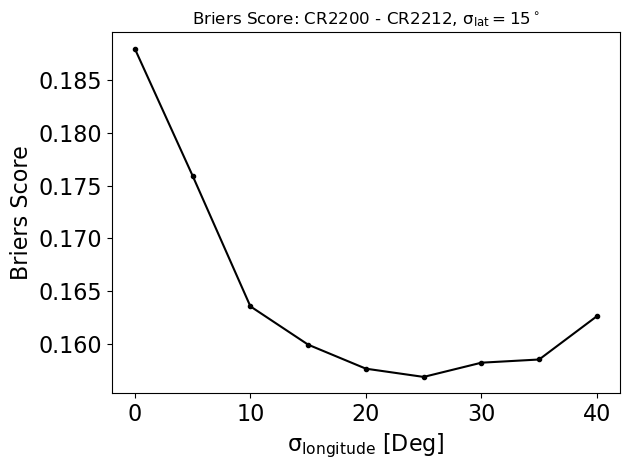

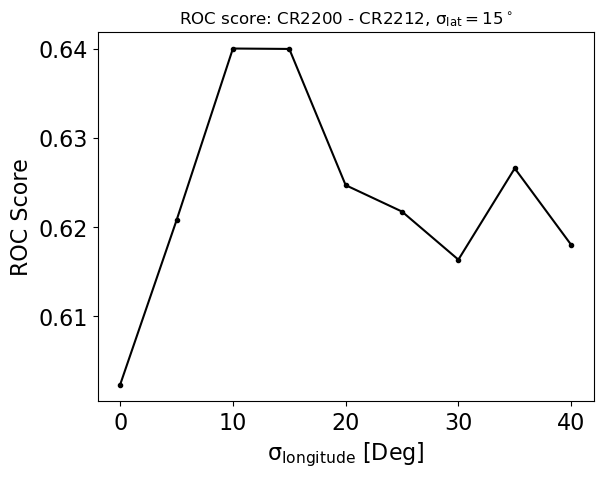

In [9]:
plt.plot(long_pert_var_list, brier_score_across_longitude_test, marker = 'o', markersize = 3, color = 'black')
plt.title(f'Briers Score: CR{CR_chunk[0]} - CR{CR_chunk[-1]}, $\mathrm{{\sigma_{{lat}}={lat_dev}^\circ}}$')
plt.xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]')
plt.ylabel('Briers Score')
plt.tight_layout()
fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\briersscoreacrosslongitude.svg"
plt.savefig(fname, format = 'svg', dpi = 300)
plt.show()

plt.plot(long_pert_var_list, ROC_socre_across_longitude_test, marker = 'o', markersize = 3, color = 'black')
plt.title(f'ROC score: CR{CR_chunk[0]} - CR{CR_chunk[-1]}, $\mathrm{{\sigma_{{lat}}={lat_dev}^\circ}}$')
plt.xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]')
plt.ylabel('ROC Score')
fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\ROCscoreacrosslongitude.svg"
plt.savefig(fname, format = 'svg', dpi = 300)
plt.show()

In [10]:



def brier_score_across_longitude(ensemble_sets, combined_data, long_min, long_max, increments, event_threshold):

    long_pert_var_list = np.linspace(long_min, long_max, increments) # degrees 

    brier_score_across_longitude = np.ones(len(long_pert_var_list))

    # Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
    for k, long_pert_var in enumerate(long_pert_var_list):

        lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR

        # Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
        for i, ensemble_members in enumerate(ensemble_sets):

            lp_ensemble_members = []

            for df in ensemble_members:

                # Perturb ensemble member in longitude
                long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
                long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
                shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)

                # resample perturbed ensemble member onto omni data timestep
                Shifted_Int = scipy.interpolate.CubicSpline(shifted_df.index, shifted_df['vsw'])
                resampled_shifted_df = pd.DataFrame({'vsw':Shifted_Int(data_chunks[i].index)}, index = data_chunks[i].index)
                lp_ensemble_members.append(resampled_shifted_df)
            
            lp_ensemble_sets.append(lp_ensemble_members)

        ## Longitudinally perturbed ensemble members
        combined_lp_ensemble_members = []

        # Create a new list of lists
        for jj in range(ensemble_size):
            list_of_cr_members = [sublist[jj]['vsw'] for sublist in lp_ensemble_sets]
            combined_lp_ensemble_members.append(pd.concat(list_of_cr_members))

        brier_score_across_longitude[k] = eef.compute_brier_score_probabilistic(ensemble_members=combined_lp_ensemble_members, observed_data=combined_data['V'], 
                                                                                    threshold=event_threshold, ensemble_size=ensemble_size)

    return brier_score_across_longitude

def save_brier_scores_to_file(brier_scores, year, event_threshold):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\forecast_evaluation\\brier_scores_{year}_{event_threshold}.csv'
    np.savetxt(fname = fname, X = brier_scores, delimiter = ',')
    return

def save_roc_scores_to_file(roc_scores, year, prob_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\forecast_evaluation\\roc_scores_{year}_{int(prob_thresh*10)}.csv'
    np.savetxt(fname = fname, X = roc_scores, delimiter = ',')
    return

In [11]:
def brier_ROC_score_across_longitude(ensemble_sets, combined_data, long_min, long_max, increments, event_threshold, probability_threshold):

    long_pert_var_list = np.linspace(long_min, long_max, increments) # degrees 

    brier_score_across_longitude = np.ones(len(long_pert_var_list))
    ROC_score_across_longitude = np.ones(len(long_pert_var_list))

    # Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
    for k, long_pert_var in enumerate(long_pert_var_list):

        lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR

        # Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
        for i, ensemble_members in enumerate(ensemble_sets):

            lp_ensemble_members = []

            for df in ensemble_members:

                # Perturb ensemble member in longitude
                long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
                long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
                shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)

                # resample perturbed ensemble member onto omni data timestep
                Shifted_Int = scipy.interpolate.CubicSpline(shifted_df.index, shifted_df['vsw'])
                resampled_shifted_df = pd.DataFrame({'vsw':Shifted_Int(data_chunks[i].index)}, index = data_chunks[i].index)
                lp_ensemble_members.append(resampled_shifted_df)
            
            lp_ensemble_sets.append(lp_ensemble_members)

        ## Longitudinally perturbed ensemble members
        combined_lp_ensemble_members = []

        # Create a new list of lists
        for jj in range(ensemble_size):
            list_of_cr_members = [sublist[jj]['vsw'] for sublist in lp_ensemble_sets]
            combined_lp_ensemble_members.append(pd.concat(list_of_cr_members))

        brier_score_across_longitude[k] = eef.compute_brier_score_probabilistic(ensemble_members=combined_lp_ensemble_members, observed_data=combined_data['V'], 
                                                                                    threshold=event_threshold, ensemble_size=ensemble_size)
        
        roc_curve = eef.generate_roc_curve_from_ensemble(ensemble_members=combined_lp_ensemble_members, observed_data=combined_data['V'], 
                                                    threshold_range=(200,800), threshold_num=30, probability_threshold = probability_threshold)

        ROC_score_across_longitude[k] = compute_roc_score(roc_curve=roc_curve)

    return brier_score_across_longitude, ROC_score_across_longitude

In [ ]:
rng = np.random.default_rng() #(place this within longitude loop for testing)

CR_chunk = CR_year_dict[2018] # one year of carrington rotations

lat_dev_list = [0,5,10,15,20,25,30,35,40] 
carrington_rotation = 27.2753*u.day
ensemble_size = 100
event_threshold = 500 # km/s
probability_threshold = 0.7

briers_set_list = []
ROC_score_set_list = []

for lat_dev in lat_dev_list:
    print(lat_dev)
    ensemble_sets = [] # List to store each CR ensemble set 
    data_chunks = [] # List to store data chunk associated with each CR

    # Read in ensemble members per CR
    for CR in CR_chunk:

        ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
        ensemble_members = [df.set_index('datetime') for df in ensemble_members]
        ensemble_sets.append(ensemble_members)

        CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
        CR_end = CR_start + pd.Timedelta(carrington_rotation.value, unit = 'days')
        data_chunks.append(omni_data.loc[CR_start:CR_end])

    # combining data frame will be useful later on
    combined_data = pd.concat(data_chunks)
    brier_list, ROC_list = brier_ROC_score_across_longitude(ensemble_sets=ensemble_sets, combined_data=combined_data, long_min = min(lat_dev_list), 
                                              long_max = max(lat_dev_list), increments = len(lat_dev_list), 
                                              event_threshold=event_threshold, probability_threshold = probability_threshold)
    briers_set_list.append(brier_list)
    ROC_score_set_list.append(ROC_list)

In [12]:
def save_brier_arr_plot(briers_set_list, year, CR_chunk):

    lat_dev_list = [0,5,10,15,20,25,30,35,40]
    long_dev_list = np.linspace(0,40,len(lat_dev_list))

    plt.imshow(briers_set_list, origin='lower', cmap = 'inferno', vmin = 0.1, vmax = 0.3)
    plt.xlabel(f'$\mathrm{{\sigma_{{longitude}}}}$ [degrees]')
    plt.ylabel(f'$\mathrm{{\sigma_{{latitude}}}}$ [degrees]')
    plt.xticks(ticks =  np.arange(len(long_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in long_dev_list])[1::2])
    plt.yticks(ticks =  np.arange(len(lat_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in lat_dev_list])[1::2])
    plt.title(f'Briers Score Evaluation: Year {year}, CR{CR_chunk[0]} - CR{CR_chunk[-1]}')
    plt.colorbar(label = f'Briers Score')
    plt.tight_layout()

    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\figures\\brier_arrays\\brier_scores_{year}.svg'

    plt.savefig(fname, dpi = 300, format = 'svg')

    return


In [ ]:
year = 2018
lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))
event_threshold = 500

plt.imshow(briers_set_list, origin='lower', cmap = 'inferno')
plt.xlabel(f'$\mathrm{{\sigma_{{longitude}}}}$ [degrees]')
plt.ylabel(f'$\mathrm{{\sigma_{{latitude}}}}$ [degrees]')
plt.xticks(ticks =  np.arange(len(long_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in long_dev_list])[1::2])
plt.yticks(ticks =  np.arange(len(lat_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in lat_dev_list])[1::2])
plt.title(f'Briers Score Evaluation: Year {year}, CR{CR_chunk[0]} - CR{CR_chunk[-1]}')
plt.colorbar(label = f'Briers Score, $\mathrm{{V_{{threshold}}}}$ = {event_threshold} km/s')

fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\briersscore2018.svg"

plt.savefig(fname, dpi = 300, format = 'svg', bbox_inches='tight')

plt.show()

plt.imshow(ROC_score_set_list, origin='lower', cmap = 'inferno')
plt.xlabel(f'$\mathrm{{\sigma_{{longitude}}}}$ [degrees]')
plt.ylabel(f'$\mathrm{{\sigma_{{latitude}}}}$ [degrees]')
plt.xticks(ticks =  np.arange(len(long_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in long_dev_list])[1::2])
plt.yticks(ticks =  np.arange(len(lat_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in lat_dev_list])[1::2])
plt.title(f'ROC Score Evaluation: Year {year}, CR{CR_chunk[0]} - CR{CR_chunk[-1]}')
plt.colorbar(label = f'ROC Score')
plt.tight_layout()

plt.show()


In [ ]:
rng = np.random.default_rng() #(place this within longitude loop for testing)
briers_arr_list = []
year_list = np.arange(2009,2020)

for year in year_list:
    print(year)
    CR_chunk = CR_year_dict[year] # one year of carrington rotations

    lat_dev_list = [0,5,10,15,20,25,30,35,40] 
    carrington_rotation = 27.2753*u.day
    ensemble_size = 100
    event_threshold = 550 # km/s
    probability_threshold = 0.5

    briers_set_list = []
    ROC_score_set_list = []

    for lat_dev in lat_dev_list:
        #print(lat_dev)
        ensemble_sets = [] # List to store each CR ensemble set 
        data_chunks = [] # List to store data chunk associated with each CR

        # Read in ensemble members per CR
        for CR in CR_chunk:

            ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
            ensemble_members = [df.set_index('datetime') for df in ensemble_members]
            ensemble_sets.append(ensemble_members)

            CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
            CR_end = CR_start + pd.Timedelta(carrington_rotation.value, unit = 'days')
            data_chunks.append(omni_data.loc[CR_start:CR_end])

        # combining data frame will be useful later on
        combined_data = pd.concat(data_chunks)
        brier_list, ROC_list = brier_ROC_score_across_longitude(ensemble_sets=ensemble_sets, combined_data=combined_data, long_min = min(lat_dev_list), 
                                                long_max = max(lat_dev_list), increments = len(lat_dev_list), 
                                                event_threshold=event_threshold, probability_threshold=probability_threshold)
        briers_set_list.append(brier_list)
        ROC_score_set_list.append(ROC_list)
        
    #save_brier_arr_plot(briers_set_list, year, CR_chunk)
    # save_brier_scores_to_file(briers_set_list, year, event_threshold)
    # save_roc_scores_to_file(ROC_score_set_list, year, probability_threshold)

### Calibration Curve

Evaluate for a specific $\sigma_{latitude}$ and $\sigma_{longitude}$

In [8]:
rng = np.random.default_rng()

year = 2018
CR_chunk = CR_year_dict[year] # one year of carrington rotations
lat_dev = 15
carrington_rotation = 27.2753*u.day

ensemble_sets = [] # List to store each CR ensemble set 
data_chunks = [] # List to store data chunk associated with each CR

# Read in ensemble members per CR
for CR in CR_chunk:

    ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
    ensemble_members = [df.set_index('datetime') for df in ensemble_members]
    ensemble_sets.append(ensemble_members)

    CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
    CR_end = CR_start + pd.Timedelta(carrington_rotation.value, unit = 'days')
    data_chunks.append(omni_data.loc[CR_start:CR_end])

# combining data frame will be useful later on
combined_data = pd.concat(data_chunks)

### Longitudinal Perturbation
long_pert_var = 0 # degrees

lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR

# Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
for i, ensemble_members in enumerate(ensemble_sets):

    lp_ensemble_members = []

    for df in ensemble_members:

        # Perturb ensemble member in longitude
        long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
        long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
        shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)

        # resample perturbed ensemble member onto omni data timestep
        Shifted_Int = scipy.interpolate.CubicSpline(shifted_df.index, shifted_df['vsw'])
        resampled_shifted_df = pd.DataFrame({'vsw':Shifted_Int(data_chunks[i].index)}, index = data_chunks[i].index)
        lp_ensemble_members.append(resampled_shifted_df)
    
    lp_ensemble_sets.append(lp_ensemble_members)

## Longitudinally perturbed ensemble members
combined_lp_ensemble_members = []

# Create a new list of lists
for i in range(ensemble_size):
    list_of_cr_members = [sublist[i]['vsw'] for sublist in lp_ensemble_sets]
    combined_lp_ensemble_members.append(pd.concat(list_of_cr_members))

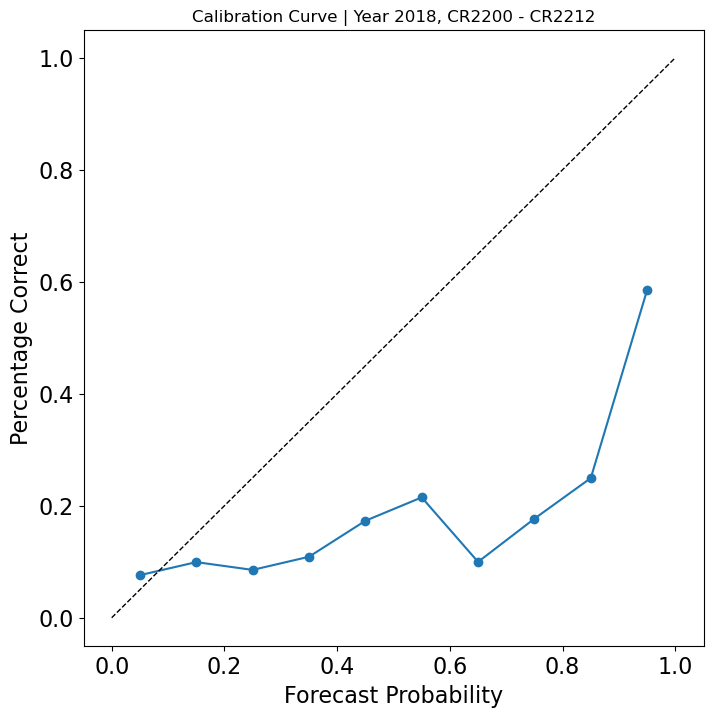

In [9]:
event_threshold = 500 #km/s

probabilistic_forecast = eef.gen_probabilistic_forecast(ensemble_members=combined_lp_ensemble_members, 
                                                        threshold=event_threshold, ensemble_size=ensemble_size)
y_prob = probabilistic_forecast
y_true = eef.generate_catagorical_forecast(forecast=combined_data['V'], threshold=event_threshold)
num_bins = 10

# Bin probabilities
bins = np.linspace(0, 1, num_bins + 1) # Generate bins
bin_indices = np.digitize(y_prob, bins) # Return the indices of the bins to which each value in input array belongs.

# Calculate percentage correct in each bin
percentage_correct = []
for bin_num in range(1, num_bins + 1):
    mask = (bin_indices == bin_num) # Create mask which isolates all forecast indices within bin being looped over
    percentage = np.mean(y_true[mask]) # calculate percentage as fraction of correct forecasts of binned indices
    percentage_correct.append(percentage)

# Calculate mean probability in each bin
mean_probabilities = [(bins[i] + bins[i + 1]) / 2 for i in range(num_bins)]

# Plot the calibration curve
plt.figure(figsize=(8, 8))
plt.plot(mean_probabilities, percentage_correct, marker='o', linestyle='-')
plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), lw = 1, linestyle = '--', color = 'black')
plt.xlabel('Forecast Probability')
plt.ylabel('Percentage Correct')
plt.title(f'Calibration Curve | Year {year}, CR{CR_chunk[0]} - CR{CR_chunk[-1]}')
plt.show()

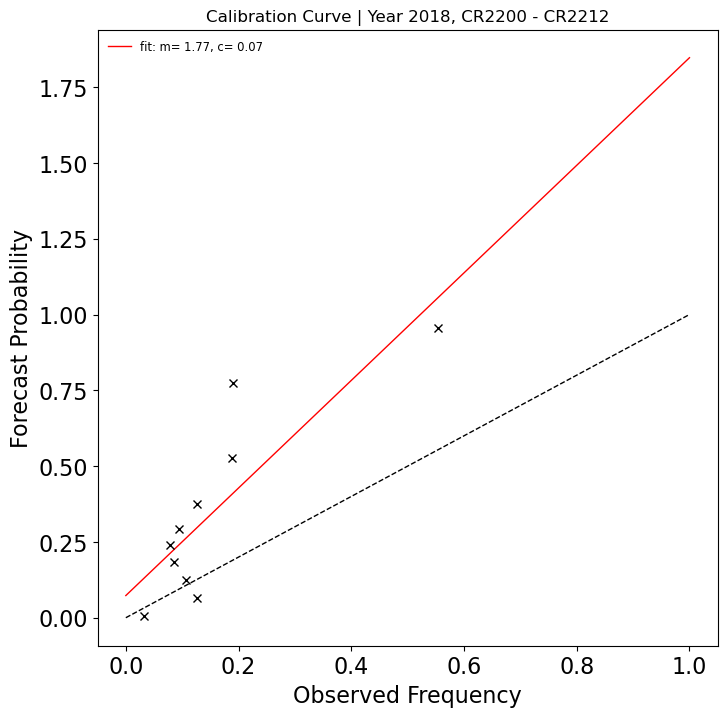

In [10]:
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy = 'quantile')

def func(x,m,c):
    return m*x + c

popt, pcov = curve_fit(func, prob_true, prob_pred)

# Plot the calibration curve
plt.figure(figsize=(8, 8))
plt.plot(np.array([0,1]), func(np.array([0,1]), *popt), 'r-', label=f'fit: m=%5.2f, c=%5.2f' % tuple(popt), lw = 1)
plt.plot(prob_true, prob_pred, marker='x', linestyle = '', color = 'black')
plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), lw = 1, linestyle = '--', color = 'black')
plt.xlabel('Observed Frequency')
plt.ylabel('Forecast Probability')
plt.title(f'Calibration Curve | Year {year}, CR{CR_chunk[0]} - CR{CR_chunk[-1]}')
plt.legend(frameon = False, fontsize = 'small')
plt.show()

In [73]:

# define bins
probability_bins = [(0,0.25),(0.26,0.5),(0.51,0.75),(0.76,1)]

# Sample data for testing
observed_probabilities = np.array([0.2, 0.4, 0.6, 0.8])
predicted_probabilities = np.array([0.3, 0.5, 0.7, 0.9])

# Number of bootstrap samples
n_bootstrap = 1000

# Bootstrap resampling and calibration error calculation
bootstrap_errors = []

for bin_start, bin_end in probability_bins:
    bin_indices = np.where((predicted_probabilities >= bin_start) & (predicted_probabilities < bin_end))[0]
    
    bootstrap_samples = [resample(zip(observed_probabilities[bin_indices], predicted_probabilities[bin_indices])) for _ in range(n_bootstrap)]
    
    bootstrap_errors_bin = [mean_squared_error(obs, pred) for obs, pred in bootstrap_samples]
    
    bootstrap_errors.append({
        'bin_start': bin_start,
        'bin_end': bin_end,
        'mean_error': np.mean(bootstrap_errors_bin),
        'ci_low': np.percentile(bootstrap_errors_bin, 2.5),
        'ci_high': np.percentile(bootstrap_errors_bin, 97.5)
    })

TypeError: object of type 'zip' has no len()

Evaluate for a set $\sigma_{latitude}$ across a range of $\sigma_{longitude}$

In [61]:
rng = np.random.default_rng()

def read_in_and_perturb_ensemble(CR_chunk, lat_dev, long_pert_var):

    carrington_rotation = 27.2753*u.day

    ensemble_sets = [] # List to store each CR ensemble set 
    data_chunks = [] # List to store data chunk associated with each CR

    # Read in ensemble members per CR
    for CR in CR_chunk:

        ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
        ensemble_members = [df.set_index('datetime') for df in ensemble_members]
        ensemble_sets.append(ensemble_members)

        CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
        CR_end = CR_start + pd.Timedelta(carrington_rotation.value, unit = 'days')
        data_chunks.append(omni_data.loc[CR_start:CR_end])

    # combining data frame will be useful later on
    combined_data = pd.concat(data_chunks)

    lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR

    # Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
    for i, ensemble_members in enumerate(ensemble_sets):

        lp_ensemble_members = []

        for df in ensemble_members:

            # Perturb ensemble member in longitude
            long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
            long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
            shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)

            # resample perturbed ensemble member onto omni data timestep
            Shifted_Int = scipy.interpolate.CubicSpline(shifted_df.index, shifted_df['vsw'])
            resampled_shifted_df = pd.DataFrame({'vsw':Shifted_Int(data_chunks[i].index)}, index = data_chunks[i].index)
            lp_ensemble_members.append(resampled_shifted_df)
        
        lp_ensemble_sets.append(lp_ensemble_members)

    ## Longitudinally perturbed ensemble members
    combined_lp_ensemble_members = []

    # Create a new list of lists
    for i in range(ensemble_size):
        list_of_cr_members = [sublist[i]['vsw'] for sublist in lp_ensemble_sets]
        combined_lp_ensemble_members.append(pd.concat(list_of_cr_members))

    return combined_lp_ensemble_members, combined_data

def compute_calibration_curve(ensemble_members, observed_data, event_threshold, num_bins):
    

    probabilistic_forecast = eef.gen_probabilistic_forecast(ensemble_members=ensemble_members, 
                                                            threshold=event_threshold, ensemble_size=ensemble_size)
    y_prob = probabilistic_forecast
    y_true = eef.generate_catagorical_forecast(forecast=observed_data, threshold=event_threshold)

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins, strategy = 'quantile')

    return (prob_true, prob_pred)

   

In [65]:
year = 2018
lat_dev = 20
long_dev_list = [0,5,10,15,20,25,30,35,40]
event_threshold = 500
num_bins = 10

calibration_curves_list = []
for long_dev in long_dev_list:
    ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_year_dict[year], lat_dev=lat_dev, long_pert_var=long_dev)
    ensemble_cal_curve = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data['V'], 
                                                event_threshold=event_threshold, num_bins=num_bins)
    calibration_curves_list.append(ensemble_cal_curve)



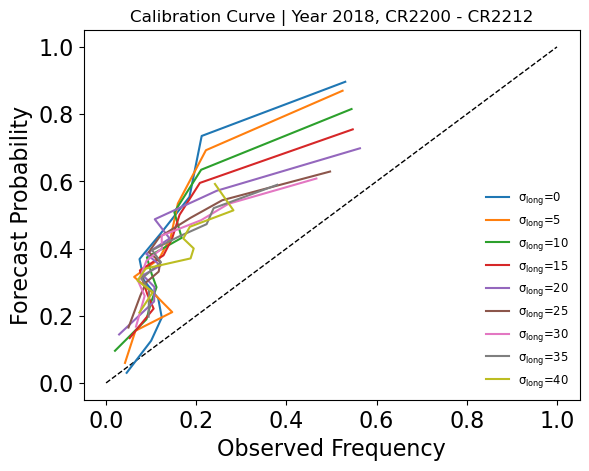

In [66]:
year = 2018
CR_chunk = CR_year_dict[2018]

plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), lw = 1, linestyle = '--', color = 'black')

for i, curve in enumerate(calibration_curves_list):
    plt.plot(curve[0], curve[1], label = f'$\mathrm{{\sigma_{{long}}}}$={long_dev_list[i]}')

plt.legend()

plt.xlabel('Observed Frequency')
plt.ylabel('Forecast Probability')
plt.title(f'Calibration Curve | Year {year}, CR{CR_chunk[0]} - CR{CR_chunk[-1]}')
plt.legend(frameon = False, fontsize = 'small')
plt.show()


### Cost Lost


In [74]:
rng = np.random.default_rng()

CR_chunk = CR_year_dict[2011] # one year of carrington rotations
lat_dev = 15
carrington_rotation = 27.2753*u.day

ensemble_sets = [] # List to store each CR ensemble set 
data_chunks = [] # List to store data chunk associated with each CR

# Read in ensemble members per CR
for CR in CR_chunk:

    ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
    ensemble_members = [df.set_index('datetime') for df in ensemble_members]
    ensemble_sets.append(ensemble_members)

    CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
    CR_end = CR_start + pd.Timedelta(carrington_rotation.value, unit = 'days')
    data_chunks.append(omni_data.loc[CR_start:CR_end])

# combining data frame will be useful later on
combined_data = pd.concat(data_chunks)

### Longitudinal Perturbation
long_pert_var = 20 # degrees

lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR

# Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
for i, ensemble_members in enumerate(ensemble_sets):

    lp_ensemble_members = []

    for df in ensemble_members:

        # Perturb ensemble member in longitude
        long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
        long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
        shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)

        # resample perturbed ensemble member onto omni data timestep
        Shifted_Int = scipy.interpolate.CubicSpline(shifted_df.index, shifted_df['vsw'])
        resampled_shifted_df = pd.DataFrame({'vsw':Shifted_Int(data_chunks[i].index)}, index = data_chunks[i].index)
        lp_ensemble_members.append(resampled_shifted_df)
    
    lp_ensemble_sets.append(lp_ensemble_members)

## Longitudinally perturbed ensemble members
combined_lp_ensemble_members = []

# Create a new list of lists
for i in range(ensemble_size):
    list_of_cr_members = [sublist[i]['vsw'] for sublist in lp_ensemble_sets]
    combined_lp_ensemble_members.append(pd.concat(list_of_cr_members))


In [75]:
### Generate HUXt deterministic forecast
CR_chunk = CR_year_dict[2011]

# Read in deterministic HUXt output
deterministic_HUXt_ouput_list = [read_deterministic_forecast_cdf(cr) for cr in CR_chunk]

# Resample deterministic forecast onto omni data timestep
resampled_deterministic_output = []
for i, df in enumerate(deterministic_HUXt_ouput_list):

    df_ = df.set_index('datetime')
    resampled_forecast = eef.interpolate_and_resample(observed_data_index = data_chunks[i].index, forecast_index=df_.index, forecast=df_['vsw'])
    resampled_deterministic_output.append(resampled_forecast)

# Create single timeseries dataframe with datetime index from omni 
deterministic_forecast = np.concatenate(resampled_deterministic_output)
deterministic_forecast = pd.DataFrame({'vsw': deterministic_forecast}, index = combined_data.index)


In [96]:
action_threshold = 500
probability_threshold = 0.4

probabilistic_forecast = eef.gen_probabilistic_forecast(ensemble_members=combined_lp_ensemble_members, threshold=action_threshold, ensemble_size=ensemble_size)
action_threshold_data = combined_data['V'] > action_threshold

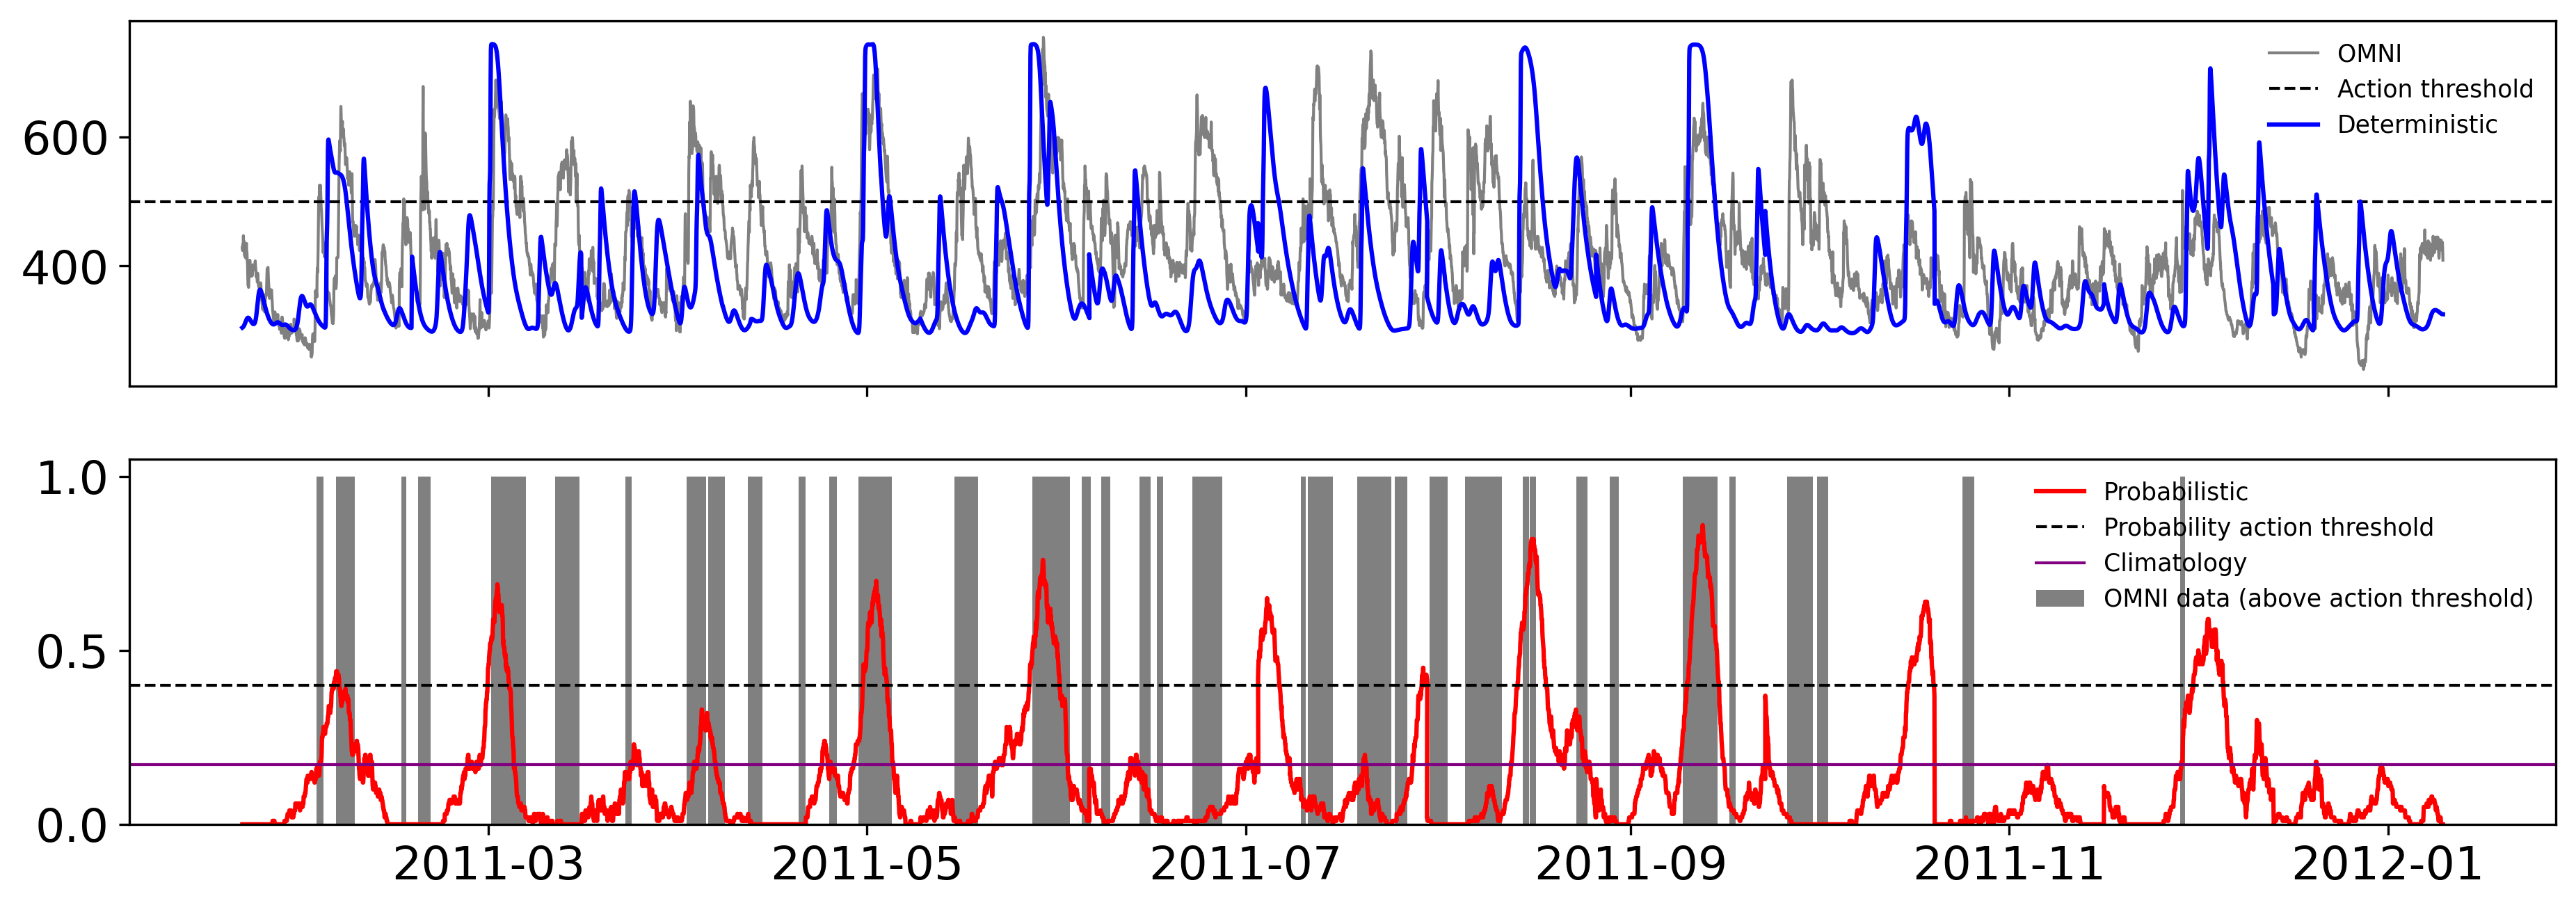

In [97]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize = (15,5), dpi = 300, sharex = True)

axes[0].plot(combined_data['V'], lw = 1, color = 'grey', label = 'OMNI')
axes[0].axhline(action_threshold, lw = 1, linestyle = '--', color = 'black', label = 'Action threshold')
axes[0].plot(deterministic_forecast['vsw'], color = 'blue', label = 'Deterministic')


axes[1].bar(action_threshold_data.index, action_threshold_data.to_numpy(), color = 'grey', label = 'OMNI data (above action threshold)')
axes[1].plot(combined_data.index, probabilistic_forecast, color = 'red', label = 'Probabilistic')
axes[1].axhline(probability_threshold, linestyle = '--', lw = 1, color = 'black', label = 'Probability action threshold')
axes[1].axhline(np.mean(action_threshold_data.to_numpy()), lw = 1, color = 'purple', label = 'Climatology')
axes[0].legend(frameon = False, fontsize = 'small')
axes[1].legend(frameon = False, fontsize = 'small')

plt.show()


In [98]:
perfect_cost = action_threshold_data
percect_loss = np.zeros(len(action_threshold_data))

climatology = np.mean(action_threshold_data.to_numpy())
climatological_cost =  probabilistic_forecast > climatology
climatological_loss = perfect_cost == (probabilistic_forecast < climatology)

deterministic_forecast_cost = deterministic_forecast['vsw'] > action_threshold
deterministic_forecast_loss = action_threshold_data == (deterministic_forecast['vsw'] < action_threshold)

ensemble_cost =  probabilistic_forecast > probability_threshold
ensemble_loss = perfect_cost == (probabilistic_forecast < probability_threshold)

In [99]:
print(f'Perfect Cost = {np.sum(perfect_cost)}C')
print(f'Climatological Cost/Loss = {np.sum(climatological_cost)}C + {np.sum(climatological_loss)}L')
print(f'Deterministic Cost/Loss = {np.sum(deterministic_forecast_cost)}C + {np.sum(deterministic_forecast_loss)}L')
print(f'Ensemble Cost/Loss = {np.sum(ensemble_cost)}C + {np.sum(ensemble_loss)}L')

Perfect Cost = 1465C
Climatological Cost/Loss = 1956C + 2325L
Deterministic Cost/Loss = 996C + 1683L
Ensemble Cost/Loss = 858C + 1645L


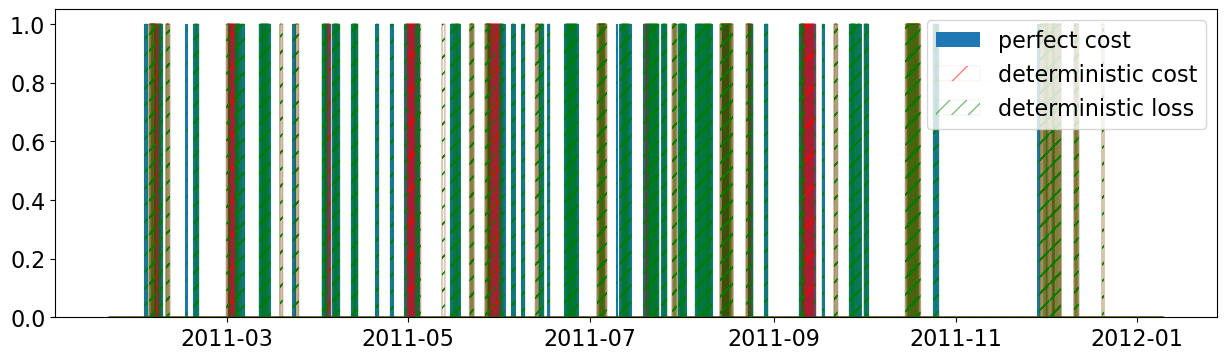

In [88]:
plt.figure(figsize = (15,4))
plt.bar(perfect_cost.index, perfect_cost, label = 'perfect cost')
plt.bar(deterministic_forecast_cost.index, deterministic_forecast_cost, label = 'deterministic cost', fill = None, lw = 0.1, hatch = '/', edgecolor = 'red', alpha = 0.5)
plt.bar(deterministic_forecast_cost.index, deterministic_forecast_loss, label = 'deterministic loss', fill = None, lw = 0.1, hatch = '//', edgecolor = 'green', alpha = 0.5)
#plt.plot(deterministic_forecast_loss, label = ' deterministic loss')

plt.legend()
plt.show()